# Defined operations

Recall that all operations must be defined with specific local gradient computation for BP to work. In this section, we will implement a minimal **autograd engine** for creating computational graphs. This starts with the base `Node` class which has a `data` attribute for storing output and a `grad` attribute for storing the global gradient. Furthermore, the base class defines a `backward` method to solve for `grad` as described above.

In [1]:
%%save
import math
import random
random.seed(42)

from typing import final


class Node:
    def __init__(self, data, parents=()):
        self.data = data
        self.grad = 0               # ∂loss / ∂self
        self._parents = parents     # parent -> self

    @final
    def sorted_graph(self):
        """Return toposorted comp graph with self as root."""
        topo = []
        visited = set()
        def dfs(node):
            if node not in visited:
                visited.add(node)
                for parent in node._parents:
                    dfs(parent)
                topo.append(node)
        dfs(self)
        return reversed(topo)

    @final
    def backward(self):
        """Send global grads backward to parent nodes."""
        self.grad = 1.0
        for node in self.sorted_graph():
            for parent in node._parents:
                parent.grad += node.grad * node._local_grad(parent)

    def _local_grad(self, parent) -> float:
        """Calculate local grads ∂self / ∂parent."""
        raise NotImplementedError("Base node has no parents.")

    def __add__(self, node):
        return BinaryOpNode(self, node, op="+")

    def __mul__(self, node):
        return BinaryOpNode(self, node, op="*")

    def __pow__(self, n):
        assert isinstance(n, (int, float)) and n != 1
        return PowOp(self, n)

    def relu(self):
        return ReLUNode(self)

    def tanh(self):
        return TanhNode(self)

    def __neg__(self):
        return self * Node(-1)

    def __sub__(self, node):
        return self + (-node)

import math
import random
random.seed(42)

from typing import final


class Node:
    def __init__(self, data, parents=()):
        self.data = data
        self.grad = 0               # ∂loss / ∂self
        self._parents = parents     # parent -> self

    @final
    def sorted_graph(self):
        """Return toposorted comp graph with self as root."""
        topo = []
        visited = set()
        def dfs(node):
            if node not in visited:
                visited.add(node)
                for parent in node._parents:
                    dfs(parent)
                topo.append(node)
        dfs(self)
        return reversed(topo)

    @final
    def backward(self):
        """Send global grads backward to parent nodes."""
        self.grad = 1.0
        for node in self.sorted_graph():
            for parent in node._parents:
                parent.grad += node.grad * node._local_grad(parent)

    def _local_grad(self, parent) -> float:
        """Calculate local grads ∂self / ∂parent."""
        raise NotImplementedError("Base node has no parents.")

    def __add__(self, node):
        return BinaryOpNode(self, node, op="+")

    def __mul__(self, node):
        return BinaryOpNode(self, node, op="*")

    def __pow__(self, n):
        assert isinstance(n, (int, float)) and n != 1
        return PowOp(self, n)

    def relu(self):
        return ReLUNode(self)

    def tanh(self):
        return TanhNode(self)

    def __neg__(self):
        return self * Node(-1)

    def __sub__(self, node):
        return self + (-node)

Next, we define the **supported operations**. Observe that only a handful are needed to implement a fully-connected neural net:

In [2]:
%%save

class BinaryOpNode(Node):
    def __init__(self, x, y, op: str):
        """Binary operation between two nodes."""
        ops = {"+": lambda x, y: x + y, "*": lambda x, y: x * y}
        self._op = op
        super().__init__(ops[op](x.data, y.data), (x, y))

    def _local_grad(self, parent):
        if self._op == "+":
            return 1.0

        elif self._op == "*":
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data

    def __repr__(self):
        return self._op


class ReLUNode(Node):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return float(parent.data > 0)

    def __repr__(self):
        return "relu"


class TanhNode(Node):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return 1 - self.data**2

    def __repr__(self):
        return "tanh"


class PowOp(Node):
    def __init__(self, x, n):
        self.n = n
        data = x.data**self.n
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

    def __repr__(self):
        return f"** {self.n}"

class BinaryOpNode(Node):
    def __init__(self, x, y, op: str):
        """Binary operation between two nodes."""
        ops = {"+": lambda x, y: x + y, "*": lambda x, y: x * y}
        self._op = op
        super().__init__(ops[op](x.data, y.data), (x, y))

    def _local_grad(self, parent):
        if self._op == "+":
            return 1.0

        elif self._op == "*":
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data

    def __repr__(self):
        return self._op


class ReLUNode(Node):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return float(parent.data > 0)

    def __repr__(self):
        return "relu"


class TanhNode(Node):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return 1 - self.data**2

    def __repr__(self):
        return "tanh"


class PowOp(Node):
    def __init__(self, x, n):
        self.n = n
        data = x.data**self.n
        super().__init__(data, (x,))

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

    def __repr__(self):
        return f"** {self.n}"

**Remark.** Note circular definition is okay since references are resolved at runtime.

<br>

## Graph vizualization

The next two functions help to visualize networks. The `trace` function just walks backward into the graph to collect all nodes and edges. This is used by the `draw_graph` which first draws all nodes, then draws all edges. For compute nodes we add a small juncture node which contains the name of the operation.

In [3]:
%%save

from graphviz import Digraph


def trace(root):
    """Builds a set of all nodes and edges in a graph."""
    # https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb

    nodes = set()
    edges = set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for parent in v._parents:
                edges.add((parent, v))
                build(parent)

    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""

    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        # Add node to graph
        uid = str(id(n))
        dot.node(name=uid, label=f"data={n.data:.3f} | grad={n.grad:.4f}", shape="record")

        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if len(n._parents) > 0:
            dot.node(name=uid + str(n), label=str(n))
            dot.edge(uid + str(n), uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + str(v))

    return dot

from graphviz import Digraph


def trace(root):
    """Builds a set of all nodes and edges in a graph."""
    # https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb

    nodes = set()
    edges = set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for parent in v._parents:
                edges.add((parent, v))
                build(parent)

    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""

    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        # Add node to graph
        uid = str(id(n))
        dot.node(name=uid, label=f"data={n.data:.3f} | grad={n.grad:.4f}", shape="record")

        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if len(n._parents) > 0:
            dot.node(name=uid + str(n), label=str(n))
            dot.edge(uid + str(n), uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + str(v))

    return dot

Creating graph for a dense unit. Observe that `x1` has a degree of 2 since it has two children.

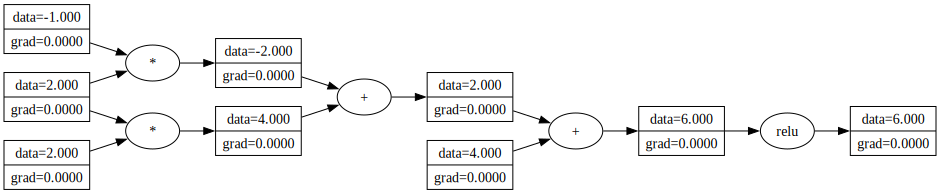

In [4]:
w0 = Node(-1.0)
w1 = Node(2.0)
b  = Node(4.0)
x  = Node(2.0)
t  = Node(3.0)

z = w0 * x + w1 * x + b
u = z.tanh()
y = z.relu()
draw_graph(y)

Gradients all check out:

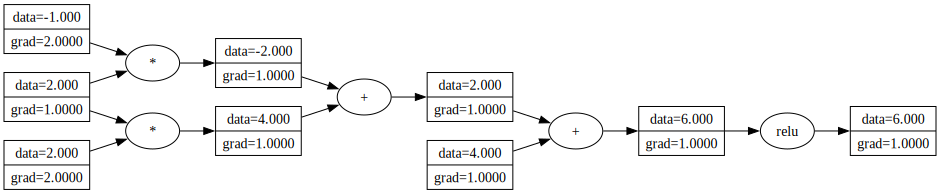

In [5]:
y.backward()
draw_graph(y)

Note that `u` is not shown in the graph and `u.grad` is zero since `y` has no dependence on `u`:

In [6]:
u.grad

0

Moreover, gradients on shared parameters **accumulate** with multiple inputs:

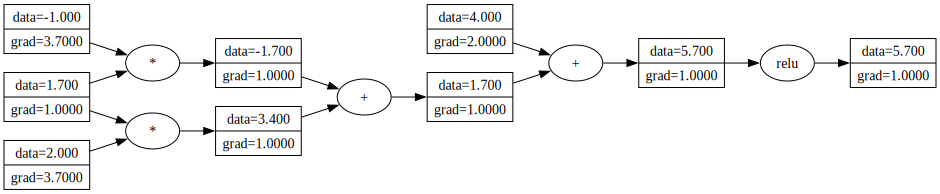

In [7]:
x1 = Node(1.7)
z1 = w0 * x1 + w1 * x1 + b
y1 = z1.relu()
y1.backward()
draw_graph(y1)